<a href="https://colab.research.google.com/github/ArmandoSep/H1B-visa-dash-app/blob/master/notebooks/H1B_visa_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# H1B Visa Aproval Project

## Project Overview:

* This is a binary classification problem

* The target is `CASE_STATUS` because it answers the business question: How likely will I get an H1B visa?

* The baseline is 57.9% of certified visas.

* A random split method was implemented.

* The logistic regresion had a 63.99% accuracy score. 

  ROC AUC = 65.9%

* The XGBoost had a 88.6% accuracy score.

  ROC AUC = 93.4%

  * Using only top 7 features: 
  
    Accuracy score: 88.8%

    ROC AUC: 92.4%



## Load the dataset

In [514]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/ArmandoSep/H1B-visa-dash-app/master/assets/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [530]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

train = pd.read_csv(DATA_PATH+'TrainH1B.csv')

## Mayority class of the target

In [531]:
# The data has balanced classes
train['CASE_STATUS'].value_counts(normalize=True)

CERTIFIED    0.579504
DENIED       0.420496
Name: CASE_STATUS, dtype: float64

## Clean the dataset

In [532]:
# Split train into train and val
train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              stratify=train['CASE_STATUS'], random_state=42)
# Basic cleaning
def wrangle(X):
  # Prevent SettingWithCopyWarning
  X = X.copy()

  # Properly formate date features
  X['EMPLOYMENT_END_DATE'] = pd.to_datetime(X['EMPLOYMENT_END_DATE'], infer_datetime_format=True)
  X['EMPLOYMENT_START_DATE'] = pd.to_datetime(X['EMPLOYMENT_START_DATE'], infer_datetime_format=True)
  X['CASE_SUBMITTED'] = pd.to_datetime(X['CASE_SUBMITTED'], infer_datetime_format=True)
  X['DECISION_DATE'] = pd.to_datetime(X['DECISION_DATE'], infer_datetime_format=True)

  # Clean the AGENT_ATTORNEY_NAME feature
  X['AGENT_ATTORNEY_NAME'] = X['AGENT_ATTORNEY_NAME'].replace(',', 'Missing')

  # Clean WORKSITE_POSTAL_CODE
  WPC = X['WORKSITE_POSTAL_CODE'].astype(str).str.split(pat = "-", expand=True)
  X['WORKSITE_POSTAL_CODE'] = WPC[0]
  X['WORKSITE_POSTAL_CODE'] = X['WORKSITE_POSTAL_CODE'].replace('NORFOLK', np.NaN)
  # X['WORKSITE_POSTAL_CODE'] = X['WORKSITE_POSTAL_CODE'].astype(float)

  # Clean EMPLOYER_POSTAL_CODE
  EPC = X['EMPLOYER_POSTAL_CODE'].astype(str).str.split(pat = "-", expand=True)
  X['EMPLOYER_POSTAL_CODE'] = EPC[0]
  X['EMPLOYER_POSTAL_CODE'] = X['EMPLOYER_POSTAL_CODE'].replace('CA 94538', '94538')
  # X['EMPLOYER_POSTAL_CODE'] = X['EMPLOYER_POSTAL_CODE'].astype(float)

  # Engineer feature: Hoy many days will the person work
  X['WORK_DURATION_DAYS'] = X['EMPLOYMENT_END_DATE'] - X['EMPLOYMENT_START_DATE']
  X['WORK_DURATION_DAYS'] = X['WORK_DURATION_DAYS'].dt.days
  X = X.drop(columns=['EMPLOYMENT_END_DATE', 'EMPLOYMENT_START_DATE'])

  # Engineees feature: anual wage rate
  X['wage'] = X['WAGE_RATE_OF_PAY_TO'].replace(0.00, X['WAGE_RATE_OF_PAY_FROM'])
  X['WAGE_UNIT_OF_PAY'] = X['WAGE_UNIT_OF_PAY'].replace(np.NaN, 'Year')
  X['WAGE_UNIT_OF_PAY'] = X['WAGE_UNIT_OF_PAY'].replace({'Year': 1, 'Hour': 2080, 'Week': 52, 'Month': 12, 'Bi-Weekly': 26})
  X['ANNUAL_WAGE'] = X['WAGE_UNIT_OF_PAY'] * X['wage']
  X = X.drop(columns=['wage', 'WAGE_RATE_OF_PAY_TO', 'WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY'])

  # Engineees feature: anual prevailing wage rate
  X['PW_UNIT_OF_PAY'] = X['PW_UNIT_OF_PAY'].replace(np.NaN, 'Hour')
  X['PW_UNIT_OF_PAY'] = X['PW_UNIT_OF_PAY'].replace({'Year': 1, 'Hour': 2080, 'Week': 52, 'Month': 12, 'Bi-Weekly': 26})
  X['ANNUAL_PREVAILING_WAGE'] = X['PW_UNIT_OF_PAY'] * X['PREVAILING_WAGE']
  X = X.drop(columns=['PREVAILING_WAGE', 'PW_UNIT_OF_PAY'])

  # Engineer feature: time taken for decision
  X['DECISION_TIME'] = X['DECISION_DATE'] - X['CASE_SUBMITTED']
  X['DECISION_TIME'] = X['DECISION_TIME'].dt.days
  X = X.drop(columns=['DECISION_DATE', 'CASE_SUBMITTED'])

  # Engineer feature: Reason
  # Drop group cases
  X = X.drop(X[X['TOTAL_WORKERS'] >=2].index)
  # Replace numbers that don't add up
  X['NEW_EMPLOYMENT'] = np.where((X.NEW_EMPLOYMENT >=2), 1, X.NEW_EMPLOYMENT)  
  X['CHANGE_EMPLOYER'] = np.where((X.CHANGE_EMPLOYER >=2), 1, X.CHANGE_EMPLOYER)  
  X['AMENDED_PETITION'] = np.where((X.AMENDED_PETITION >=2), 1, X.AMENDED_PETITION) 
  # Reverse OneHotEncoding
  X['REASON'] = X[['NEW_EMPLOYMENT',
        'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
        'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION']].idxmax(axis=1, skipna=True)
  # Drop unneded columns
  X = X.drop(columns=[])
  
  # Drop unnedded columns
  X = X.drop(columns=['Ob', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT',
                      'PUBLIC_DISCLOSURE_LOCATION', 'ORIGINAL_CERT_DATE', 'EMPLOYER_BUSINESS_DBA',
                      'EMPLOYER_ADDRESS', 'EMPLOYER_COUNTRY', 'TOTAL_WORKERS', 'NEW_EMPLOYMENT',
                      'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT','NEW_CONCURRENT_EMPLOYMENT', 
                      'CHANGE_EMPLOYER', 'AMENDED_PETITION', 'PW_SOURCE_OTHER', 'PW_SOURCE', 'JOB_TITLE'])

  return X


train = wrangle(train)
val = wrangle(val)

## Linear model: Logistic Regression

In [533]:
# Only use features with low cardinality because of the OneHotEncoder
features = ['VISA_CLASS', 'AGENT_REPRESENTING_EMPLOYER', 'FULL_TIME_POSITION', 
                'PW_WAGE_LEVEL', 'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 
                'SUPPORT_H1B', 'LABOR_CON_AGREE', 'NAICS_CODE', 'REASON', 
                'PW_SOURCE_YEAR','WORK_DURATION_DAYS', 'ANNUAL_WAGE', 
                'ANNUAL_PREVAILING_WAGE', 'DECISION_TIME']
target = 'CASE_STATUS'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


In [534]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(random_state=42)
)

pipeline.fit(X_train, y_train)
print('Logistic Regression - Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)

Logistic Regression - Validation Accuracy 0.6399560922063666


In [535]:
# Get coefficients

model = pipeline.named_steps['logisticregression']

encoder = pipeline.named_steps['onehotencoder']
encoder_columns = encoder.transform(X_val).columns

coefficients = pd.Series(model.coef_[0], encoder_columns)
coefficients.sort_values(ascending=False)

VISA_CLASS_E-3 Australian            0.364376
ANNUAL_PREVAILING_WAGE               0.283029
DECISION_TIME                        0.235460
H1B_DEPENDENT_N                      0.194016
WILLFUL_VIOLATOR_N                   0.184253
PW_WAGE_LEVEL_nan                    0.146194
VISA_CLASS_H-1B1 Singapore           0.104216
ANNUAL_WAGE                          0.090706
LABOR_CON_AGREE_Y                    0.086966
VISA_CLASS_H-1B1 Chile               0.055663
SUPPORT_H1B_Y                        0.053366
REASON_NEW_CONCURRENT_EMPLOYMENT     0.045450
REASON_NEW_EMPLOYMENT                0.041138
FULL_TIME_POSITION_N                 0.022473
AGENT_REPRESENTING_EMPLOYER_Y        0.013216
WILLFUL_VIOLATOR_Y                   0.011730
AGENT_REPRESENTING_EMPLOYER_N        0.003933
REASON_CONTINUED_EMPLOYMENT         -0.003501
REASON_AMENDED_PETITION             -0.006478
SUPPORT_H1B_N                       -0.007085
LABOR_CON_AGREE_N                   -0.017671
AGENT_REPRESENTING_EMPLOYER_nan   

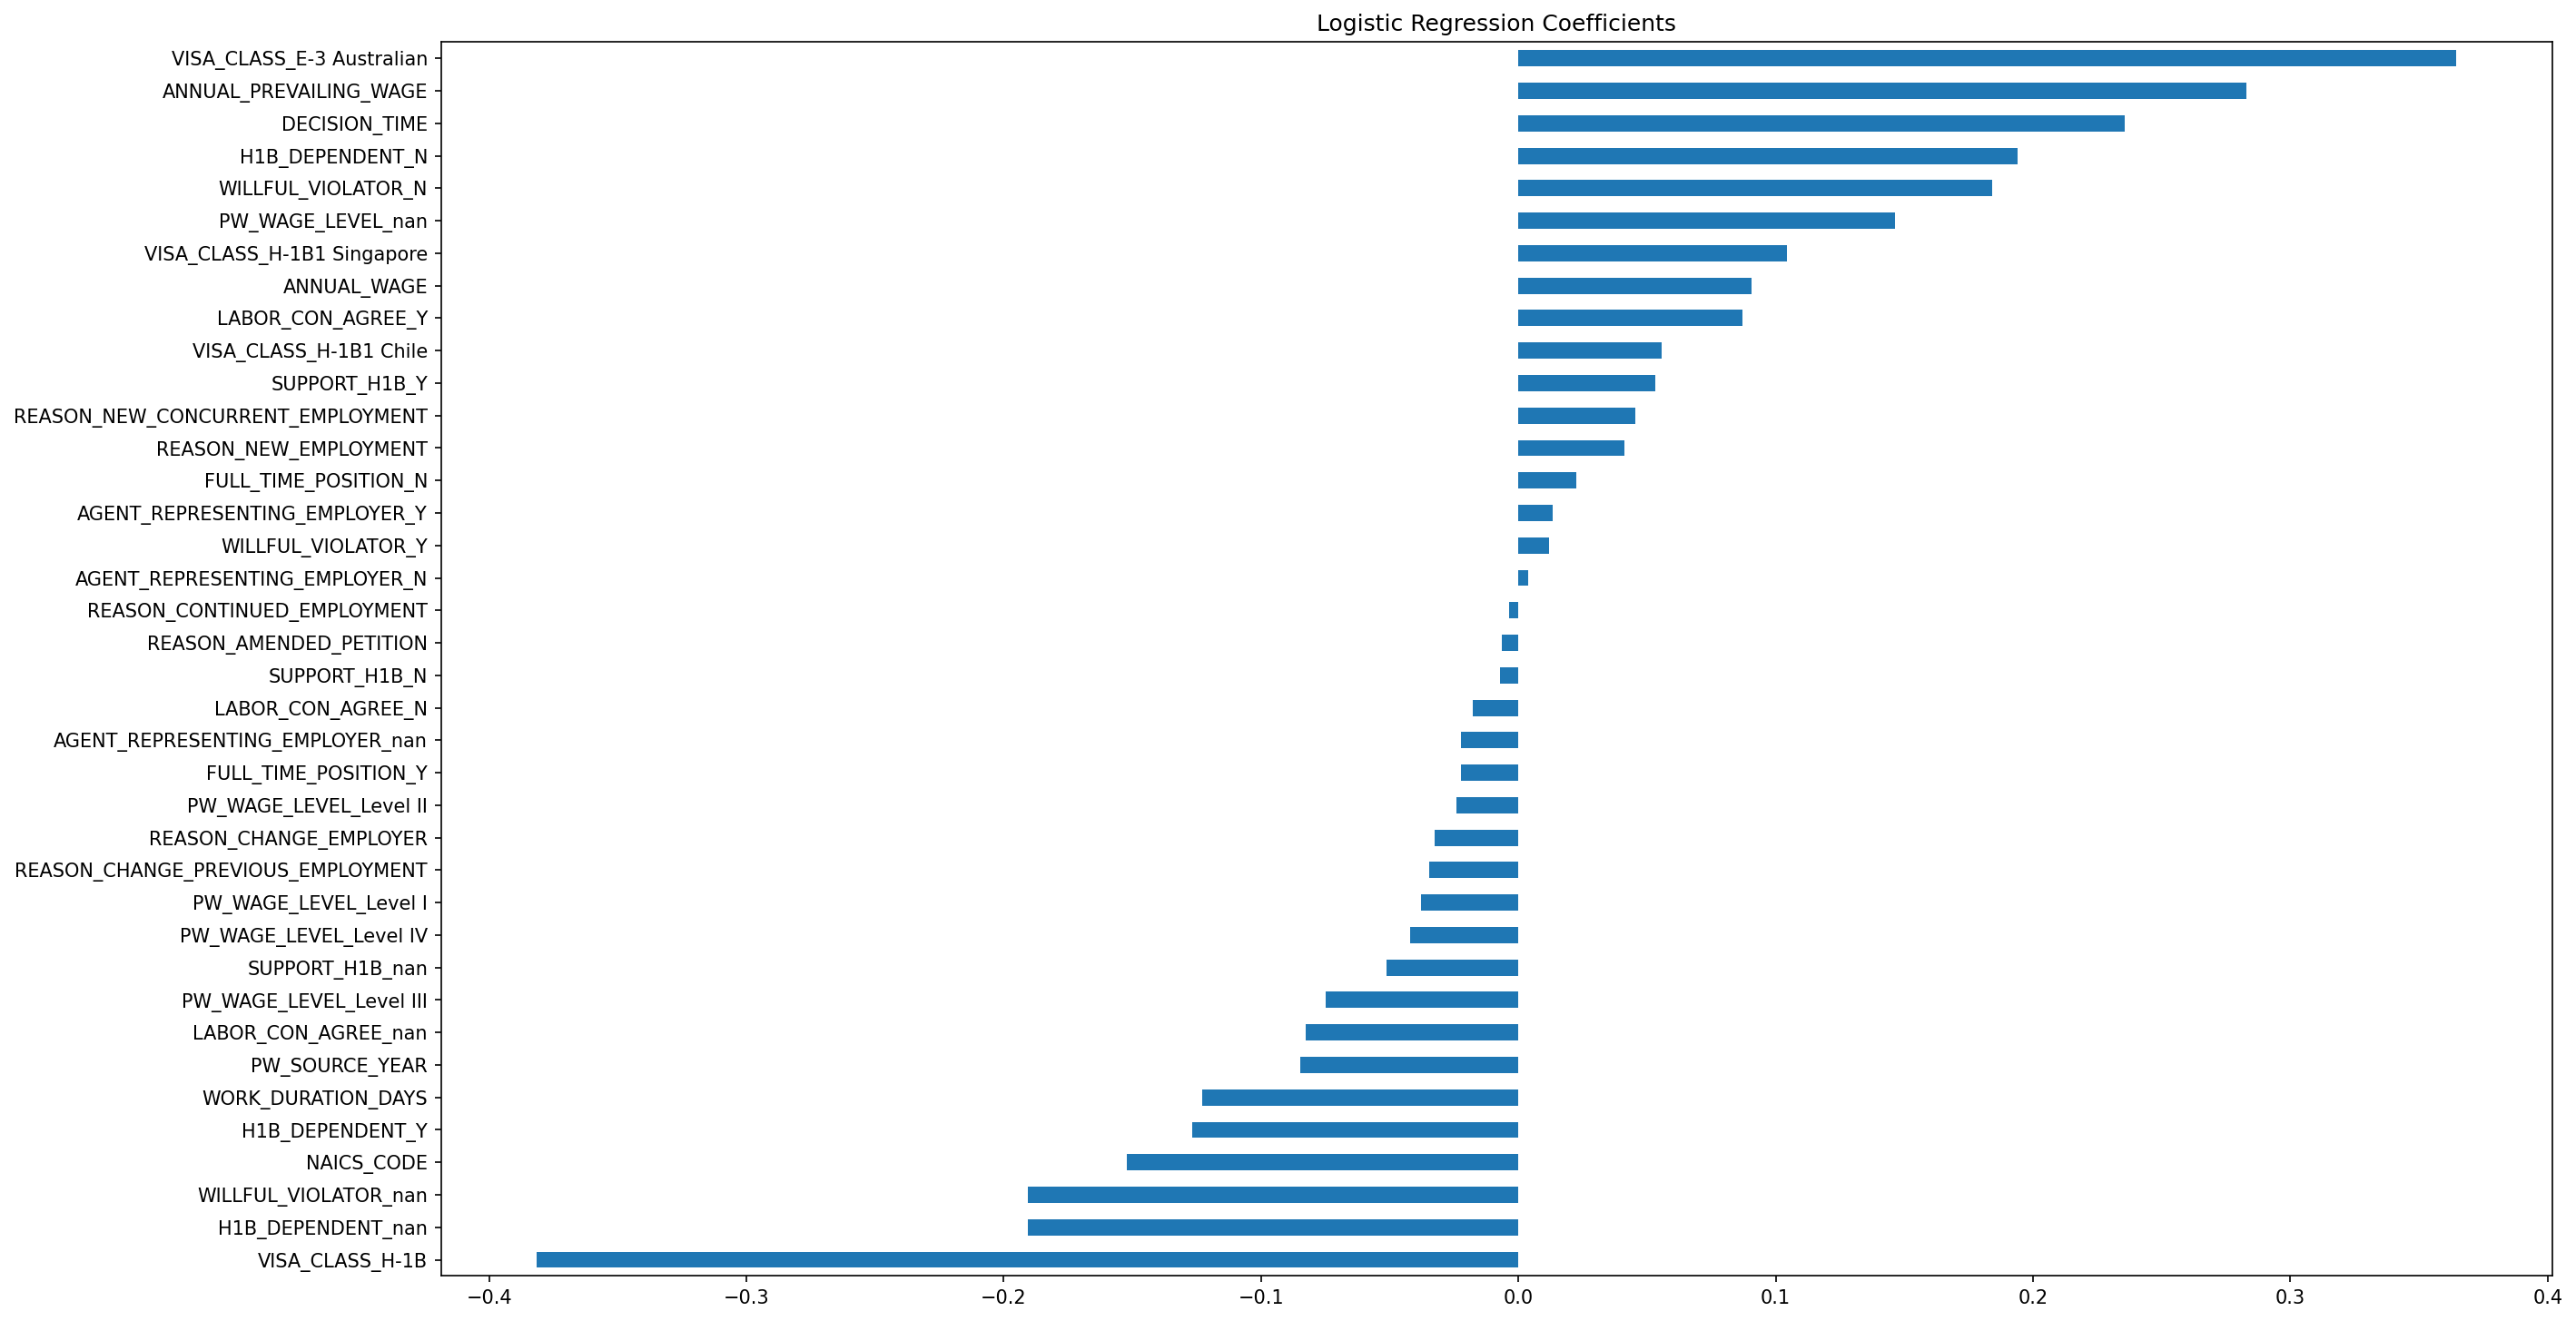

In [536]:
# Plot coefficients
import matplotlib.pyplot as plt


plt.figure(figsize=(20,12))
plt.title('Logistic Regression Coefficients')
coefficients.sort_values().plot.barh();

### Precision and recall on Logistic Regression

In [537]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

   CERTIFIED       0.64      0.86      0.73       524
      DENIED       0.65      0.34      0.44       387

    accuracy                           0.64       911
   macro avg       0.64      0.60      0.59       911
weighted avg       0.64      0.64      0.61       911



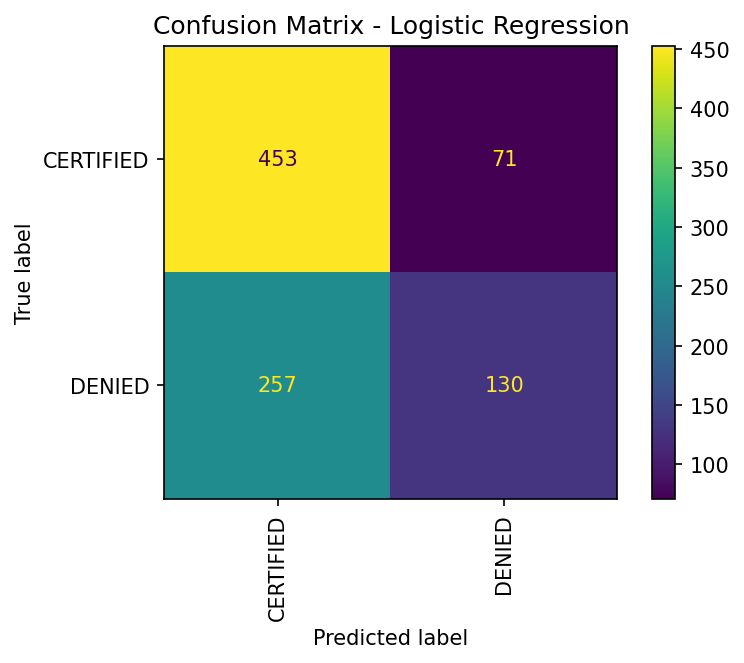

In [538]:
from sklearn.metrics import plot_confusion_matrix

cml = plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f',xticks_rotation='vertical');
cml.ax_.set_title('Confusion Matrix - Logistic Regression'); 

### ROC AUC Score for Logistic Regression

In [539]:
from sklearn.metrics import roc_auc_score

class_index = 1
y_pred_proba = pipeline.predict_proba(X_val)[:, class_index]
print(f'Logistic Regression - ROC AUC for class {class_index}:')
print(roc_auc_score(y_val, y_pred_proba))

Logistic Regression - ROC AUC for class 1:
0.6599404304002209


## Tree ensemble: XGBoost for gradient boosting



In [540]:
# Arrange data into X features matrix and y target vector
target = 'CASE_STATUS'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [541]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

xgmodel = XGBClassifier(
    n_estimators=1000,
    max_depth=9,
    learning_rate=0.2,
    n_jobs=-1,
)

eval_set = [(X_train_processed, y_train),
            (X_val_processed, y_val)]

# Fit on train
xgmodel.fit(X_train_processed, y_train,
          eval_set=eval_set,
          eval_metric='error',
          early_stopping_rounds=50) 

[0]	validation_0-error:0.079091	validation_1-error:0.119649
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.076355	validation_1-error:0.12404
[2]	validation_0-error:0.071429	validation_1-error:0.116356
[3]	validation_0-error:0.069513	validation_1-error:0.116356
[4]	validation_0-error:0.067323	validation_1-error:0.118551
[5]	validation_0-error:0.062397	validation_1-error:0.116356
[6]	validation_0-error:0.062124	validation_1-error:0.11416
[7]	validation_0-error:0.059661	validation_1-error:0.115258
[8]	validation_0-error:0.055829	validation_1-error:0.11416
[9]	validation_0-error:0.055556	validation_1-error:0.115258
[10]	validation_0-error:0.050082	validation_1-error:0.118551
[11]	validation_0-error:0.048714	validation_1-error:0.119649
[12]	validation_0-error:0.046524	validation_1-error:0.120746
[13]	validation_0-error:0.045703	validation_1-error:0.11964

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [542]:
from sklearn.metrics import accuracy_score

y_pred = xgmodel.predict(X_val_processed)
print('XGBoost - Validation Accuracy', accuracy_score(y_val, y_pred))

XGBoost - Validation Accuracy 0.8858397365532382


In [543]:
from sklearn.metrics import roc_auc_score

class_index = 1
y_pred_proba = xgmodel.predict_proba(X_val_processed)[:, class_index]
roc_score = roc_auc_score(y_val, y_pred_proba) # Ranges from 0-1, higher is better
print(f'XGBoost - ROC AUC for class {class_index}:', '\n', roc_score)

XGBoost - ROC AUC for class 1: 
 0.9338447048148806


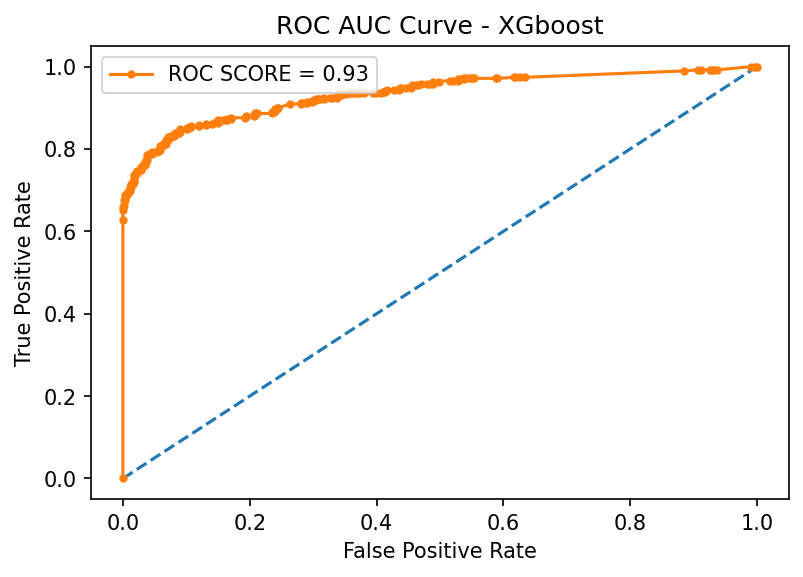

In [544]:
from sklearn.metrics import roc_curve

# Mayority class probabilities
mc_probs = [0 for _ in range(len(y_val))]

# calculate roc curves
mc_fpr, mc_tpr, _ = roc_curve(y_val, mc_probs, pos_label='DENIED')
fpr, tpr, _ = roc_curve(y_val, y_pred_proba, pos_label='DENIED')
# plot the roc curve for the model
plt.plot(mc_fpr, mc_tpr, linestyle='--')
plt.plot(fpr, tpr, marker='.', label=f'ROC SCORE = {roc_score:.2f}')
# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - XGboost')
# show the legend
plt.legend()
# show the plot
plt.show()

### Permutation Importance


In [545]:
import eli5
from eli5.sklearn import PermutationImportance


# Pipeline for permuter
permuter = PermutationImportance(
    xgmodel,
    scoring='accuracy',
    n_iter=5, # Run each permutation 5 times and take the average
    random_state=42
)

permuter.fit(X_val_processed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.2,
                                              max_delta_step=0, max_depth=9,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [546]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(
    ascending=False)

DECISION_TIME                  0.351701
PW_SOURCE_YEAR                 0.021734
NAICS_CODE                     0.012075
ANNUAL_WAGE                    0.007684
AGENT_REPRESENTING_EMPLOYER    0.006586
ANNUAL_PREVAILING_WAGE         0.004391
WORKSITE_COUNTY                0.003293
EMPLOYER_CITY                  0.002195
AGENT_ATTORNEY_CITY            0.002195
PW_WAGE_LEVEL                  0.001976
REASON                         0.001317
AGENT_ATTORNEY_NAME            0.001098
H1B_DEPENDENT                  0.000878
LABOR_CON_AGREE                0.000659
AGENT_ATTORNEY_STATE           0.000439
EMPLOYER_NAME                  0.000000
WORKSITE_STATE                 0.000000
WILLFUL_VIOLATOR               0.000000
SOC_NAME                       0.000000
FULL_TIME_POSITION             0.000000
SUPPORT_H1B                    0.000000
VISA_CLASS                     0.000000
WORKSITE_POSTAL_CODE          -0.000439
WORKSITE_CITY                 -0.000659
EMPLOYER_POSTAL_CODE          -0.000659


In [547]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.3517 ± 0.0270,DECISION_TIME
0.0217 ± 0.0058,PW_SOURCE_YEAR
0.0121 ± 0.0054,NAICS_CODE
0.0077 ± 0.0024,ANNUAL_WAGE
0.0066 ± 0.0044,AGENT_REPRESENTING_EMPLOYER
0.0044 ± 0.0054,ANNUAL_PREVAILING_WAGE
0.0033 ± 0.0048,WORKSITE_COUNTY
0.0022 ± 0.0028,EMPLOYER_CITY
0.0022 ± 0.0020,AGENT_ATTORNEY_CITY
0.0020 ± 0.0043,PW_WAGE_LEVEL


In [548]:
minimun_importance = 0.004
mask = permuter.feature_importances_ > minimun_importance
mask

array([False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False])

In [549]:
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_train_selected.shape

(3654, 6)

In [550]:
# Fit new model
transformer = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformer.fit_transform(X_train_selected)
X_val_transformed = transformer.transform(X_val_selected)

model = XGBClassifier(
    n_estimators=1000,
    max_depth=9,
    learning_rate=0.2,
    n_jobs=-1,
)

eval_set = [(X_train_transformed, y_train),
            (X_val_transformed, y_val)]

# Fit on train
model.fit(X_train_transformed, y_train,
          eval_set=eval_set,
          eval_metric='error',
          early_stopping_rounds=50) 

# Accuracy score
y_pred = model.predict(X_val_transformed)
print('XGBoost 9 features - Validation Accuracy', accuracy_score(y_val, y_pred))

[0]	validation_0-error:0.084839	validation_1-error:0.117453
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.083196	validation_1-error:0.115258
[2]	validation_0-error:0.081554	validation_1-error:0.116356
[3]	validation_0-error:0.08046	validation_1-error:0.116356
[4]	validation_0-error:0.079639	validation_1-error:0.121844
[5]	validation_0-error:0.079091	validation_1-error:0.122942
[6]	validation_0-error:0.077723	validation_1-error:0.119649
[7]	validation_0-error:0.075807	validation_1-error:0.119649
[8]	validation_0-error:0.072523	validation_1-error:0.116356
[9]	validation_0-error:0.071702	validation_1-error:0.115258
[10]	validation_0-error:0.071702	validation_1-error:0.111965
[11]	validation_0-error:0.068966	validation_1-error:0.115258
[12]	validation_0-error:0.068418	validation_1-error:0.11416
[13]	validation_0-error:0.068145	validation_1-error:0.1152

### Precision and recall on XGBoost with 9 features

In [551]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

   CERTIFIED       0.87      0.95      0.91       524
      DENIED       0.93      0.80      0.86       387

    accuracy                           0.89       911
   macro avg       0.90      0.88      0.88       911
weighted avg       0.89      0.89      0.89       911



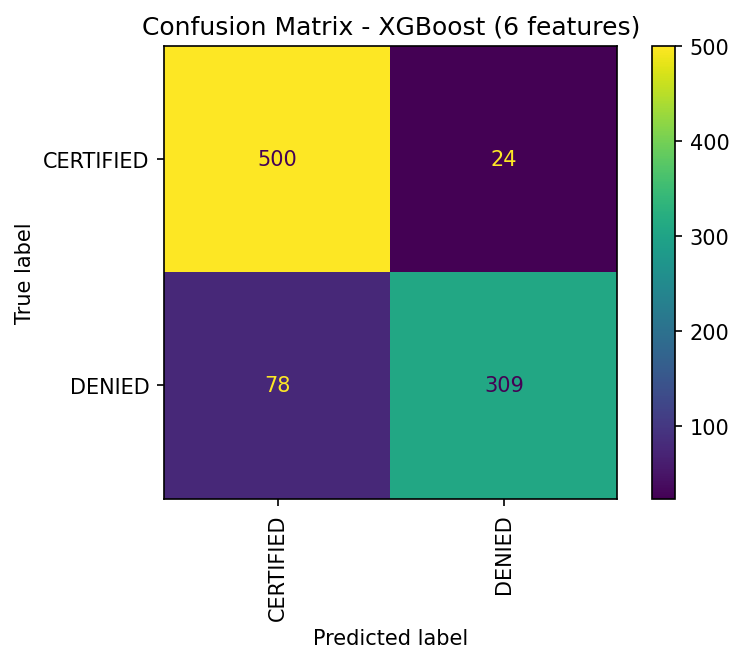

In [552]:
from sklearn.metrics import plot_confusion_matrix
cmrf = plot_confusion_matrix(model, X_val_transformed, y_val, values_format='.0f',xticks_rotation='vertical');
cmrf.ax_.set_title('Confusion Matrix - XGBoost (6 features)'); 

### ROC AUC Score

In [553]:
from sklearn.metrics import roc_auc_score

class_index = 1
y_pred_proba = model.predict_proba(X_val_transformed)[:, class_index]
roc_score = roc_auc_score(y_val, y_pred_proba) # Ranges from 0-1, higher is better
print(f'XGBoost using top 6 features- ROC AUC for class {class_index}:', '\n', roc_score)

XGBoost using top 6 features- ROC AUC for class 1: 
 0.9236542596208849


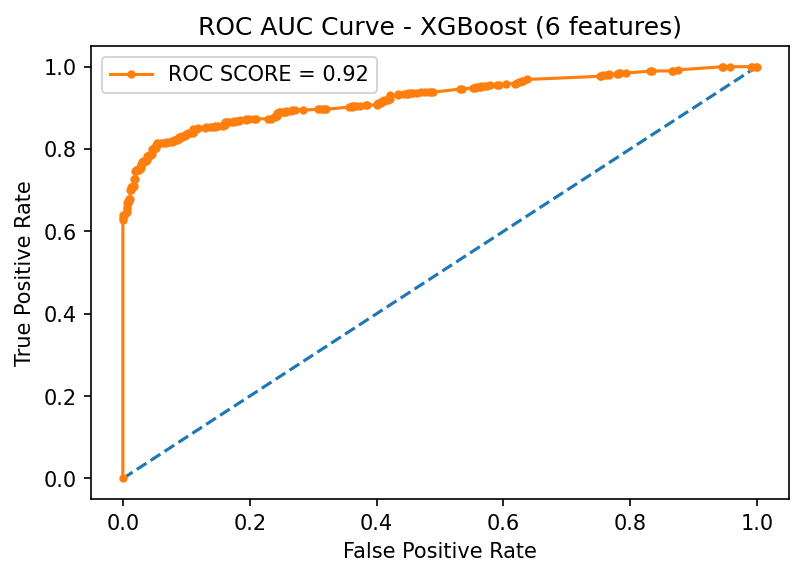

In [554]:
from sklearn.metrics import roc_curve

# Mayority class probabilities
mc_probs = [0 for _ in range(len(y_val))]

# calculate roc curves
mc_fpr, mc_tpr, _ = roc_curve(y_val, mc_probs, pos_label='DENIED')
fpr, tpr, _ = roc_curve(y_val, y_pred_proba, pos_label='DENIED')
# plot the roc curve for the model
plt.plot(mc_fpr, mc_tpr, linestyle='--')
plt.plot(fpr, tpr, marker='.', label=f'ROC SCORE = {roc_score:.2f}')
# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - XGBoost (6 features)')
# show the legend
plt.legend()
# show the plot
plt.show()

### Explain individual prediction with shapley value plots

In [555]:
import shap

row = X_val_selected.iloc[[124]]

explainer = shap.TreeExplainer(model)
row_processed = transformer.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row,
    link = 'logit' # For classification, this shows prodicted probabilities
)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [556]:
# Function to explain predictions

feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [557]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [558]:
print('Top 3 reasons for certified visa:')
for i, pro in enumerate(pros, start=1):
  feature_name, feature_value = pro
  print(f'{i}. {feature_name} is {feature_value}.')

print('\n')
print('Cons:')
for i, con in enumerate(cons, start=1):
  feature_name, feature_value = con
  print(f'{i}. {feature_name} is {feature_value}.')

Top 3 reasons for certified visa:
1. DECISION_TIME is 0.
2. AGENT_REPRESENTING_EMPLOYER is nan.
3. ANNUAL_PREVAILING_WAGE is 74027.0.


Cons:
1. NAICS_CODE is 541511.
2. ANNUAL_WAGE is 75000.0.
3. PW_SOURCE_YEAR is 2016.0.


In [559]:
def explain(row_number):
  positive_class = 'CERTIFIED'
  positive_class_index = 0

  # Get and process the data for the row
  row = X_val_selected.iloc[[row_number]]
  row_transformed = transformer.transform(row)

  # Make predictions (includes predicted probability)
  pred = model.predict(row_transformed)[0]
  pred_proba = model.predict_proba(row_transformed)[0, positive_class_index]
  pred_proba *= 100
  if pred != positive_class:
      pred_proba = 100 - pred_proba


  # Show prediction and probability
  print(f'The model predicts that the visa is {pred}, with {pred_proba:.0f}% probability.')

  # Get shapley additive explanations
  shap_values = explainer.shap_values(row_transformed)

  # Get top 3 'pros and cons' for certified
  feature_names = row.columns
  feature_values = row.values[0]
  shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
  cons = shaps.sort_values(ascending=False)[:3].index
  pros = shaps.sort_values(ascending=True)[:3].index

  # Show top 3 reasons for prediction
  print('\n')
  print('Top 3 reasons for result:')
  evidence = pros if pred == positive_class else cons
  for i, info in enumerate(evidence, start=1):
    feature_name, feature_value = info
    print(f'{i}. {feature_name} is {feature_value}.')


  # Show top 1 counter-argument agains prediction
  print('\n')
  print('Top counter-argument against prediction:')
  evidence = cons if pred == positive_class else pros
  feature_name, feature_value = evidence[0]
  print(f' - {feature_name} is {feature_value}.')

  # Show Shapley Values Force Plot
  shap.initjs()
  return shap.force_plot(
      base_value=explainer.expected_value,
      shap_values=shap_values,
      features=row,
      link='logit'
  )

explain(322)


The model predicts that the visa is CERTIFIED, with 85% probability.


Top 3 reasons for result:
1. DECISION_TIME is 7.
2. ANNUAL_WAGE is 106891.2.
3. PW_SOURCE_YEAR is 2016.0.


Top counter-argument against prediction:
 - NAICS_CODE is 541690.


### Download the model for the Dash App


In [ ]:
from joblib import dump
dump(transformer, 'transformer.joblib', compress=True)
dump(model, 'model.joblib', compress=True)

In [ ]:
from google.colab import files
files.download('model.joblib')
files.download('transformer.joblib')